In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math


import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch_lr_finder import LRFinder
import torch.nn.functional as F

from sklearn.metrics import r2_score
np.random.seed(14) # For reproducibility 
torch.manual_seed(14) # For reproducibility 

In [2]:
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t  # L96_model_XYtend Adds the option to ouptput the subgrid tendencies (effect of Y on X)
from L96_model_XYtend import EulerFwd, RK2, RK4 

In [3]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01*time_steps

# Create a "synthetic world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=Forcing)
# Get training data for the neural network. 

#- Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue,_,_,xytrue = W.run(dt, T,store=True)


In [4]:
# Specify a path
PATH = "../04Subgrid-parametrization-pytorch/networks/network_3_layers_100_epoches.pth"
# Load
model = torch.load(PATH)
model.keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [5]:
for name in model.keys():
    print (name)


linear1.weight
linear1.bias
linear2.weight
linear2.bias
linear3.weight
linear3.bias


In [6]:
epsilon = 1e-9#1e-9
## get the weight and bias
def get_weight(modelname):
    Ws = []
    Bs = []
    for (i,name) in enumerate (model.keys()):
        if i %2 ==0:
            Ws.append(np.array(model[name]))
        else: Bs.append(np.array(model[name]))
    return Ws,Bs


# forward pass to calculate the output of each layer
def forward_pass(data,Ws,Bs):
    L = len(Ws)                  
    forward = [data]+[None]*L

    for l in range(L-1):
        forward[l+1] = np.maximum(0,Ws[l].dot(forward[l])) + Bs[l]

    ## for last layer that does not have activation function
    
    forward[L] = Ws[L-1].dot(forward[L-1]) +Bs[L-1]
    return forward

def rho(w,l):  return w + [0.0,0.0,0.0,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [0.0,0.0,0.0,0.0,0.0][l] * (z**2).mean()**.5+epsilon

## backward pass to compute the LRP of each layer. Same rule applied to the fisrt layer (input layer)
def onelayer_LRP(W,B,forward,nz,zz): 
    mask = np.zeros((nz))
    mask[zz] = 1 
    L = len(W)
    R = [None]*L + [forward[L]*mask] 

    for l in range(0,L)[::-1]:
        w = rho(W[l],l)
        b = rho(B[l],l)
        z = incr(w.dot(forward[l])+b,l)                  # step 1
        s = np.array(R[l+1]) / np.array(z)               # step 2
        c = w.T.dot(s)                                   # step 3
        R[l] = forward[l]*c                              # step 4
    
    return R


def LRP_alllayer(data, model):
    """inputs: 
            data: for single sample, with the right asix, the shape is (nz,naxis)
            model: dictionary of weights and biases
        output: 
            LRP, shape: (nx,L+1) that each of the column consist of L+1 array
            Relevance of fisrt layer's pixels """
    nx = data.shape[0]
    ## step 1: get the wieghts
    Ws, Bs = get_weight(model)
    
    ## step 2: call the forward pass to get the intermediate layers output
    inter_layer = forward_pass(data,Ws,Bs)
    
    
    ## loop over all z and get the LRP of each layer
    R_all = [None]*nx
    relevance = np.zeros((nx,nx))
    for xx in range(nx):
        R_all[xx] = onelayer_LRP(Ws,Bs,inter_layer,nx,xx)
        relevance[xx,:] = R_all[xx][0]
    
    return np.stack(R_all),relevance


In [7]:
R_many = []
for case in (range(200)):
    inputs = np.copy(Xtrue[case,:])
    
    _,Rs  = LRP_alllayer(inputs,model)
    R_many.append(Rs)

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
Rstack = np.stack(R_many)
print(np.shape(Rs))
print(np.shape(Rstack))

(8, 8)
(200, 8, 8)


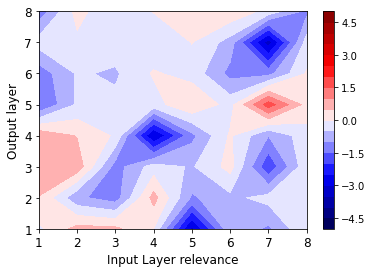

In [25]:
fig, ax = plt.subplots(1,1)
vect = np.arange(-5,5.1,0.5)
pl = ax.contourf(np.arange(1,9),np.arange(1,9), np.mean(Rstack,0), vect , cmap=plt.get_cmap('seismic'))
ax.set_ylabel('Output layer',fontsize = 12)
ax.set_xlabel('Input Layer relevance',fontsize = 12)
ax.tick_params(axis='both', labelsize=12 )

fig.colorbar(pl)
fig.savefig('LRP-L96.jpeg',bbox_inches = 'tight',dpi = 100)

In [9]:
# now take gradient - nabla_x(y) - note data was not normalized in this example!

In [38]:
#define network structure in pytorch 
import torch.nn.functional as FF

class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16) # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16) # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
#         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [39]:
model = Net_ANN()
model.load_state_dict(torch.load(PATH))
model.eval()

Net_ANN(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
)

In [43]:
epsilon = 1e-2
R_many = []
std_vec = np.std(Xtrue,axis=0)
print(std_vec)
for case in (range(200)):
    inputs = np.copy(Xtrue[case,:])
    # estimate dy/dx = (y(x+epsilon)-y(x))/epsilon
    # TODO need to perturb every components
    pred = model(torch.Tensor(inputs))
    perturb = np.zeros(np.shape(inputs))
    Rs = np.zeros((len(inputs),len(pred)))
    for j in range(len(inputs)):
        perturb[j] = epsilon
        perturb = perturb#*std_vec # percent change
        Rs[j,] = ( model(torch.Tensor(inputs+perturb))-model(torch.Tensor(inputs)) ).detach().numpy() /(np.sum(perturb))
    R_many.append(Rs)

[4.55719436 4.49180031 4.48200123 4.57005852 4.67042184 4.55764743
 4.65432827 4.49010761]


In [44]:
Rstack = np.stack(R_many)
print(np.shape(Rs))
print(np.shape(Rstack))
print(np.shape(R_many))

(8, 8)
(200, 8, 8)
(200, 8, 8)


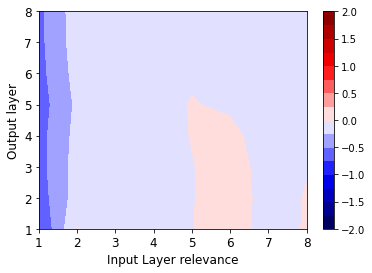

In [46]:
fig, ax = plt.subplots(1,1)
vect = np.arange(-2,2.1,0.25)
pl = ax.contourf(np.arange(1,9),np.arange(1,9), np.mean(Rstack,0), vect , cmap=plt.get_cmap('seismic'))
ax.set_ylabel('Output layer',fontsize = 12)
ax.set_xlabel('Input Layer relevance',fontsize = 12)
ax.tick_params(axis='both', labelsize=12 )

fig.colorbar(pl)
fig.savefig('LRP-L96-gradient.jpeg',bbox_inches = 'tight',dpi = 100)